# Effects of Weather Events on Flight Delays and Cancellations

## Introduction

This project seeks to form a causal relationship of weather events on the frequency of commercial airline flight delays and cancellations. Flight data was compiled from the Bureau of Transportation Statistics website; weather events were taken from a Kaggle webpag [https://www.kaggle.com/sobhanmoosavi/us-weather-events] based on the paper "Short and Long-term Pattern Discovery Over Large-Scale Geo-Spatiotemporal Data" by Moosavi, et al. All flights in 2016-2019 from the busiest 24 airports in 2018, and the weather events in those cities, were selected.

## Data Fields

The data required extensive preprocessing before analysis; details can be found in the Exploratory Data Analysis (EDA) writeup. Processed data can be found in the `departure_events.csv` file. The origin city and departure date uniquely identify each record. All other fields represent the daily summary of each airport. `departure_events.csv` has the following columns:

* ORIGIN: Three-letter IATA airport code
* DepartureDate: Date of the flights' departures
* ArrivDelay: Arriving flights delayed
* DepartDelay: Departing flights delayed
* Flights: Total departing flights
* WeatherCancelled: Departing flights cancelled due to weather
* WeatherDelayed: Departing flights delayed due to weather
* Cold: Whether the daily temperature dropped below -10.7 F (0 or 1)
* Fog: Presence of fog (0, 1=Light, 2=Heavy)
* Hail: Presence of hail (0 or 1)
* Wind: Wind over 40 mph (0 or 1)
* Rain: Presence of rain (0, 1=Light, 2=Medium, 3=Heavy)
* Sleet: Presence of sleet (0 or 1). Note: The paper did not distinguish between hail and sleet; this had to be done manually. Details are given in the EDA writeup.
* Snow: Presence of snow (0, 1=Light, 2=Medium, 3=Heavy)
* FracCancelled: Fraction of the departing flights cancelled due to weather
* FracDelayed: Fraction of the departing flights delayed due to weather
* Month: Numerical month of the year (1-12)
* Season: (Winter, Spring, Summer, Fall)
* Region: Region of the country based on the location of the airport (West, Midwest, Northeast, South, Florida)

Several of these columns will be removed during this step of the process.

## Exploratory Data Analysis

Before we do any training on the data, let's look at what the data is telling us.

In [1]:
# from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import plotly.graph_objects as go
# import plotly.io as pio
# from scipy.stats import t, ttest_ind
import seaborn as sns
# import statsmodels.api as sm
import os
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
save_plots = True; save_plots = False #whether to save the resulting plots
pd.options.mode.chained_assignment = None #turns off warnings for data replacements

DEPARTURES = 0; ARRIVALS = 1; PATHS = 2
stopwatch = TimeTracker.TimeTracker()

In [3]:
'''For each missing hour in the 24-hour day, introduce one undelayed, uncancelled flight.
We need those "flights" to avoid dividing by zero later.'''
def fill_hourly_gaps(hourly_summary):
    origin_dest = hourly_summary.columns[0] #'ORIGIN' or 'DEST'
    for airport in AIRPORTS:
        for year in range(min(hourly_summary.Year), max(hourly_summary.Year)+1):
            hours_missing = np.setdiff1d(
                np.arange(24), hourly_summary.loc[(
                    hourly_summary[origin_dest] == airport)
                    & (hourly_summary.Year == year)].Hour.to_numpy())
            n = len(hours_missing)
            new_rows = pd.DataFrame([n*[airport], n*[year], hours_missing, n*[1], n*[0], n*[0]],
                                    index=hourly_summary.columns).transpose()
            # print(airport, year, hours_missing)
            hourly_summary = pd.concat([new_rows, hourly_summary])
    return hourly_summary.sort_values([origin_dest, 'Year', 'Hour'], ignore_index=True)

In [4]:
'''Set the portion of flights per day cancelled and delayed, and groups them by period.
dataset: Whether these are departures(0), arrivals(1), or paths(2) (both).'''
def get_periodic_summaries(df, case, period='Month'):
    df['Flights'] = 1 #for portions
    paths_case = case==PATHS
    categories = [
        ['Flights', 'ORIGIN', 'DepartureTime', 'WeatherDelayed', 'WeatherCancelled'],
        ['Flights', 'DEST', 'ArrivalTime', 'WeatherDelayed', 'WeatherCancelled'],
        ['Flights', 'ORIGIN', 'DEST', 'DepartureTime', 'WeatherDelayed', 'WeatherCancelled']][case]
    df = df[categories]
    if period=='Month':
        df[period] = df[[categories[2], 'DepartureTime'][paths_case]].str[5:7].astype(int)
    elif period=='Hour':
        df[period] = df[[categories[2], 'DepartureTime'][paths_case]].str[11:13].astype(int)        
    else:
        raise ValueError('function not equipped for period ', period)
    df['Year'] = df[[categories[2], 'DepartureTime'][paths_case]].str[:4].astype(int)
    summary = df.groupby([[categories[1], 'Year', period],
                          ['ORIGIN', 'DEST', 'Year', period]][paths_case]).sum().reset_index()
    # A couple of flights left on 12/31/2019 and arrived on 1/01/2020. Delete that arrival group.
    if case==ARRIVALS:
        summary = summary[summary.Year < 2020]
    return summary

In [5]:
# Set the portion of flights per day cancelled and delayed, and groups them by departure & arrival airport.
# Dates and times are by departure.
def get_per_airport_summaries(df, period='Month'):
    df['Flights'] = 1 #for portions
    df = df[['Flights', 'ORIGIN', 'DEST', 'DepartureTime', 'WeatherDelayed', 'WeatherCancelled']]
    if period=='Month':
        df[period] = df['DepartureTime'].str[5:7].astype(int)
    else:
        raise ValueError('function not equipped for period ', period)
    df['Year'] = df['DepartureTime'].str[:4].astype(int)
    summary = df.groupby(['ORIGIN', 'DEST', 'Year', period]).sum().reset_index()
    # summary['WeatherDelayed'] /= summary.Flights
    # summary['WeatherCancelled'] /= summary.Flights
    return summary

In [6]:
'''An individual plot within the summary plot. The df needs to be a Nx2 array of
delay rates and then cancellation rates.'''
def indiv_plot(ax, df, title, xlabel, ylabel, period, normalize, ymax, vertLines,
               case, lastrow=4):
    if period=='Month':
        x = np.arange(1, len(MONTHS)+1)
    elif period=='Hour': #Any remaining value for period will result in an error.
        x = np.arange(24)
    if df is not None:
        if normalize:
            ax.plot(x, 100*df.iloc[:,lastrow-1], color='b', lw=3, ls='--', label='Delays')
            ax.plot(x, 100*df.iloc[:,lastrow], color='r', lw=2.5, label='Cancellations')
        else:         
            ax.plot(x, df['Flights'], color='k', lw=2, label='Flights')
    if vertLines:
        lw = 1; ls = '--'; color='k'
        ax.plot(2*[4 + 2*case], [0, ymax], lw=lw, ls=ls, c=color)
        ax.plot(2*([[23, 1][case]]), [0, ymax], lw=lw, ls=ls, c=color)
        
    ax.set_title(title, fontsize=12)
    ax.set_xticks([x, x[::3]][period=='Hour'])
    if period=='Month':
        ax.set_xticklabels(MONTHS, fontsize=6)
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.set_ylim([0,ymax])
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    return ax

In [7]:
'''Plot of departure and arrival statistics from each airport. Miami has significant discrepancies
between departure and arrival delays; highlight them if desired.'''
def periodic_summary_by_airport(
        periodic_departures, periodic_arrivals, period='Month', delaysCancels=True,
        normalize=True, highlightMiami=True, vertLines=False):
    nrows, ncols = 2, 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
    fig.subplots_adjust(hspace=0.2, wspace=[0.4, 0.2][normalize], bottom=0.16, top=0.83)
    for i in range(nrows):
        airport_summaries = [periodic_departures, periodic_arrivals][i].groupby(
            [['ORIGIN','DEST'][i], period]).sum().drop(['Year'], axis=1).reset_index()
        for j in range(ncols):
            airport = AIRPORTS[j]
            df = airport_summaries[airport_summaries[['ORIGIN','DEST'][i]]==airport]
            if normalize:
                df['WeatherDelayed'] /= df.Flights
                df['WeatherCancelled'] /= df.Flights
            ylabel = ['', ['Departure','Arrival'][i] + ['s', ' %'][normalize]][j==0]
            ax = indiv_plot(axs[i, j], df=df, title=['', airport_names_map[airport]][i==0],
                            xlabel=['', period][i==nrows-1], ylabel=ylabel, period=period,
                            normalize=normalize, ymax=[6e3, 5][normalize], vertLines=vertLines, case=i)
            if airport=='MIA' and highlightMiami: #Highlight departure/arrival delay discrepancy
                ax.set_facecolor((1.0, 1.0, 0.5))
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, borderaxespad=0.5)
    fig.suptitle(['Flights','Weather Delays and Cancellations'][delaysCancels] + ' by Airport',
                 fontsize=16)
    if save_plots:
        plt.savefig(period + 'lySummariesByAirport.png')
    plt.show()

In [8]:
'''Plot of statistics per route.'''
def periodic_summary_by_route(periodic_routes, period='Month', normalize=True):
    nrows = ncols = 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.2, bottom=0.16, top=0.9)
    for i in range(nrows):
        dest = AIRPORTS[i]
        for j in range(ncols):
            origin = AIRPORTS[j]
            if j == i:
                df = None
            else:
                df = periodic_routes[(periodic_routes.ORIGIN==origin) & (periodic_routes.DEST==dest)]\
                    .groupby([period]).sum().drop(['Year'], axis=1).reset_index()
                df['WeatherDelayed'] /= df.Flights #Normalization
                df['WeatherCancelled'] /= df.Flights
            ax = indiv_plot(
                axs[i, j], df=df, title=['', 'From ' + origin][i==0], 
                xlabel=['', period][i==nrows-1], ylabel=['', 'To ' + dest][j==0],
                period=period, normalize=normalize, ymax=6, vertLines=False, case=None, lastrow=3)
        if i==0 and j==nrows-1:
            handles, labels = ax.get_legend_handles_labels()
    fig.suptitle('Percent of Weather Delays and Cancellations by Route', fontsize=16)
    fig.legend(handles, labels, loc='lower center', ncol=2, borderaxespad=1)
    if save_plots:
        plt.savefig(period + 'lySummariesByAirport.png')
    plt.show()

## Data collection

In [9]:
# Get the weather data.
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)

print('Importing flight data')
flight_data = pd.read_csv('flights_with_weather.csv')

# Get airport names, which are written manually to allow for name customization.
airport_names_map = {'ATL':'Atlanta', 'JFK':'New York JFK', 'MIA':'Miami', 'ORD':"Chicago O'Hare"}
flight_data['DepAirport'] =  flight_data.ORIGIN.map(airport_names_map)
flight_data['ArrAirport'] =  flight_data.DEST.map(airport_names_map)

monthly_arrivals = get_periodic_summaries(flight_data, case=ARRIVALS)
monthly_departures= get_periodic_summaries(flight_data, case=DEPARTURES)
monthly_routes = get_periodic_summaries(flight_data, case=PATHS)

Importing flight data


## Summary plots

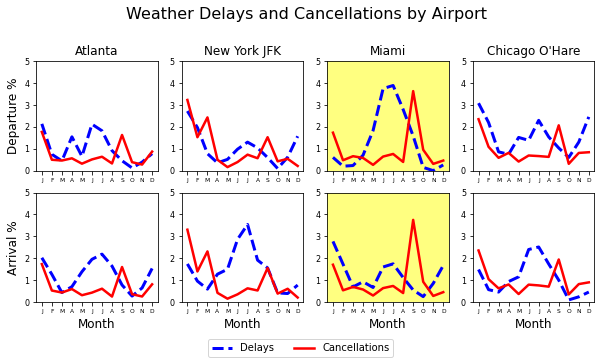

In [10]:
# Plot arrivals and departure monthly summaries over each airport
MONTHS = list('JFMAMJJASOND')
AIRPORTS = list(airport_names_map.keys())
    
periodic_summary_by_airport(monthly_departures, monthly_arrivals)

Contrary to what we would expect, there are some significant differences between departure and arrival
delays and cancellations. Miami has many more departure delays than arrival delays in the summer, and a
lesser but reversed effect is true at JFK. Miami is known for having frequent thunderstorms during the
summer; perhaps they affect the departure process more than the arrival process. Also notice that there
is a large cancellation spike for Miami in September. This was likely caused by Hurricane Irma in September
2017, which shut down Miami International Airport. Because our weather does not account for actual
hurricanes, if we left these cancelled flights in, the model would associate the heavy rain and wind with
a lot of cancellations here. Therefore, we should remove them.

In [11]:
# Locate Hurricane Irma dates for Miami (around 09/10/2017)
miami_sept_2017 = flight_data[((flight_data.ORIGIN == 'MIA') | (flight_data.DEST == 'MIA')) & (
    flight_data.DepartureTime.str[:10] > '2017-09-06') & (flight_data.DepartureTime.str[:10] < '2017-09-17')]
miami_sept_2017['Day'] = miami_sept_2017.DepartureTime.str[8:10].astype(int)
miami_summary = (miami_sept_2017.groupby(['Day']).sum().reset_index())[[
    'Day','Flights','WeatherDelayed','WeatherCancelled']]
miami_summary['CancelledFrac'] = miami_summary.WeatherCancelled/miami_summary.Flights
print('September 2017 cancellations in Miami:\n', miami_summary[['Day', 'CancelledFrac']])

September 2017 cancellations in Miami:
    Day  CancelledFrac
0    7       0.075758
1    8       0.573529
2    9       1.000000
3   10       1.000000
4   11       1.000000
5   12       0.250000
6   13       0.191176
7   14       0.078947
8   15       0.118421
9   16       0.132353


In [12]:
# The hardest hit days were between Sep. 8-13, 2017, including a complete shutdown Sep. 9-11. Drop those dates.
dates_dep = flight_data.DepartureTime.str[:11]
dates_arr = flight_data.ArrivalTime.str[:11]
flights_to_drop = flight_data[((flight_data.ORIGIN == 'MIA') | (flight_data.DEST == 'MIA')) & (
    dates_dep > '2017-09-07') & (dates_dep < '2017-09-14') & (dates_arr > '2017-09-07') & (
        dates_arr < '2017-09-14')].index
flight_data.drop(flights_to_drop, inplace=True)
del(miami_summary, miami_sept_2017, dates_arr, dates_dep, flights_to_drop) #No longer needed

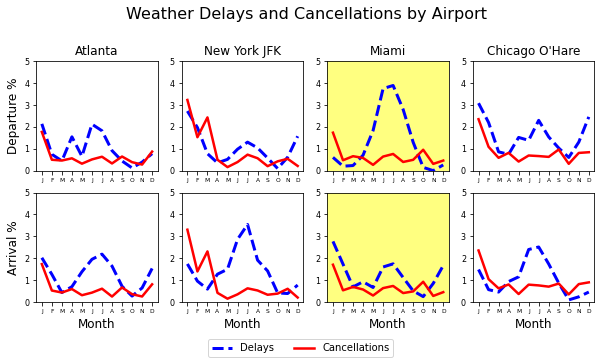

In [13]:
# Let's see what the plots look like now.
monthly_arrivals = get_periodic_summaries(flight_data, case=ARRIVALS)
monthly_departures= get_periodic_summaries(flight_data, case=DEPARTURES)
monthly_routes = get_periodic_summaries(flight_data, case=PATHS)
periodic_summary_by_airport(monthly_departures, monthly_arrivals)

Miami's September spikes are gone. Notice that the other airports also lose some smaller spikes caused
by the flights that were scheduled to and from Miami during Hurricane Irma.

Let's see if there are any more particular trends between the airports. We construct another, 4x4 plot of
delay and cancellation rates from each of our four airports to each other airport.

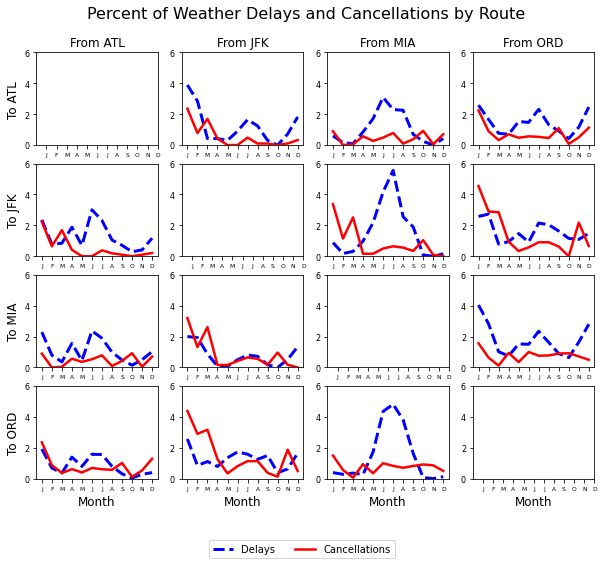

In [14]:
periodic_summary_by_route(monthly_routes)

The asymetry between departure and arrival delays is now spread around the individual routes.
For instance, the lack of symmetry between Miami's departure weather delays to JFK and O'Hare and
arrival delays from them is stark. The lack of this effect at the other three airports suggest this
is an actual issue with delays from Miami International Airport and not a bug in the data. However,
the cancellation data is nearly symmetric, suggesting that when flights are cancelled due to
weather, both departing and arriving flights are cancelled.

Now let's see if there is a correlation between time of day and delays/cancellations.

In [15]:
hourly_departures = get_periodic_summaries(flight_data, case=DEPARTURES, period='Hour')
hourly_arrivals = get_periodic_summaries(flight_data, case=ARRIVALS, period='Hour')

Some hours of the day, particularly early in the morning, have no scheduled flights. The graph
cannot be set up without these missing time spots. The following method fills them.

In [16]:
print('Filling zero-flight hours in hourly summaries')
hourly_departures = fill_hourly_gaps(hourly_departures)
hourly_arrivals = fill_hourly_gaps(hourly_arrivals)

Filling zero-flight hours in hourly summaries


Let's see when these lack of flights take place.

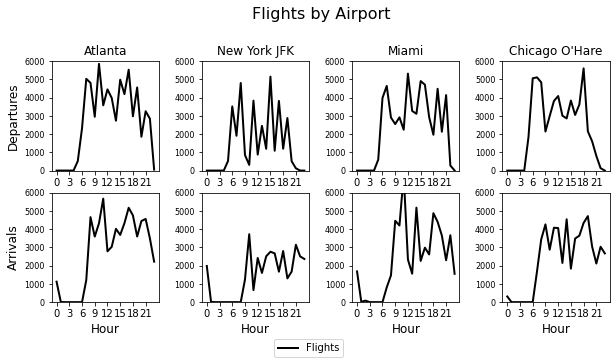

In [17]:
periodic_summary_by_airport(hourly_departures, hourly_arrivals, period='Hour',
                            delaysCancels=False, normalize=False, highlightMiami=False)

In general, flights depart between 5 AM - 11 PM and arrive between 6 AM - midnight. Very few of
our flights are scheduled to depart or arrive outside of these timeframes. Note that this timeframe
is somewhat shorter for JFK, possibly due to flight time restrictions.

We will visually denote these times on the next set of charts: Hourly delay and cancellation rates,
per airport, categorized by arrivals and departures.

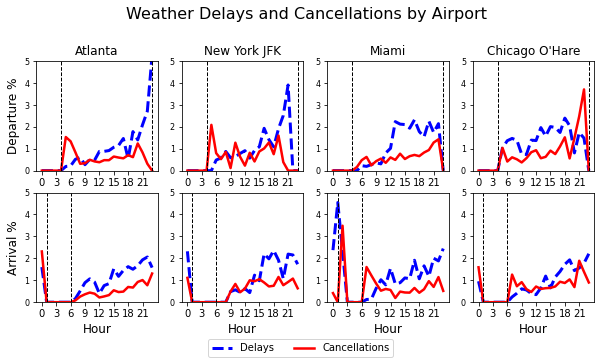

In [18]:
periodic_summary_by_airport(hourly_departures, hourly_arrivals, period='Hour',
                            highlightMiami=False, vertLines=True)

As explained above, the spikes for Miami's arrivals and Atlanta's and Chicago's departures
occur during a window of very few flights and should be taken with a grain of salt. Note that
both departure and arrival delay percentages are uncommon in the morning but increase as the
day goes on; this effect is much sharper for Miami's departures after 12 PM. The overall pattern
is probably due to both thunderstorms' being more common in the afternoon and airports' runway
capacity being reduced during heavy rains.